In [1]:
import sys
sys.dont_write_bytecode = True

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from lib.utils import imshow
from lib.misc import generate_histogram, otsu
from lib.colors import color_balance, equalize, binarize
from lib.kernel import create_gaussian_kernel
from lib.transform import custom_transform, median_transform

import contextlib
with contextlib.redirect_stdout(None):
    np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [2]:
image = cv.imread('./images/Initial & repeat MRI in MS-Free Dataset/AA/1/IM_00036.TIF')
im_gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
im_gray[im_gray <= 20] = 0

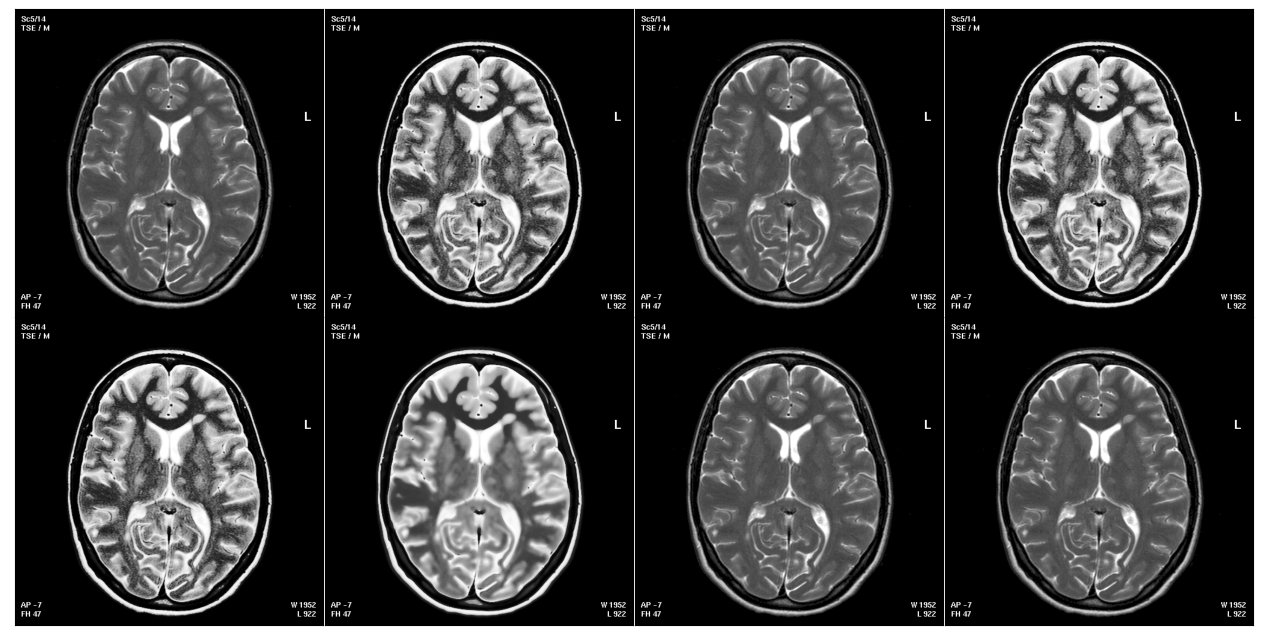

In [3]:
imshow(
    im_gray,
    equalize(cv.fastNlMeansDenoising(im_gray, None, 1, 7, 21)),
    color_balance(im_gray, 0, 255),
    equalize(im_gray),
    cv.fastNlMeansDenoising(equalize(im_gray), None, 1, 7, 21),
    equalize(cv.fastNlMeansDenoising(im_gray, None, h = 11, searchWindowSize = 101)),
    cv.fastNlMeansDenoising(color_balance(im_gray, 0, 255), None, 1, 7, 21),
    color_balance(cv.fastNlMeansDenoising(im_gray, None, 1, 7, 21), 0, 255),
    cols = 4
)

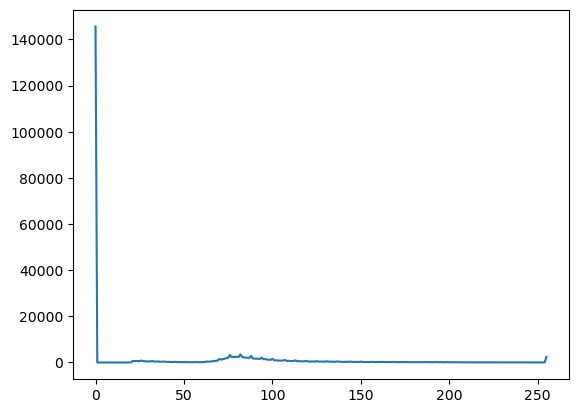

In [4]:
denoised_equalized = color_balance(im_gray, 0, 255)
plt.plot(generate_histogram(denoised_equalized))

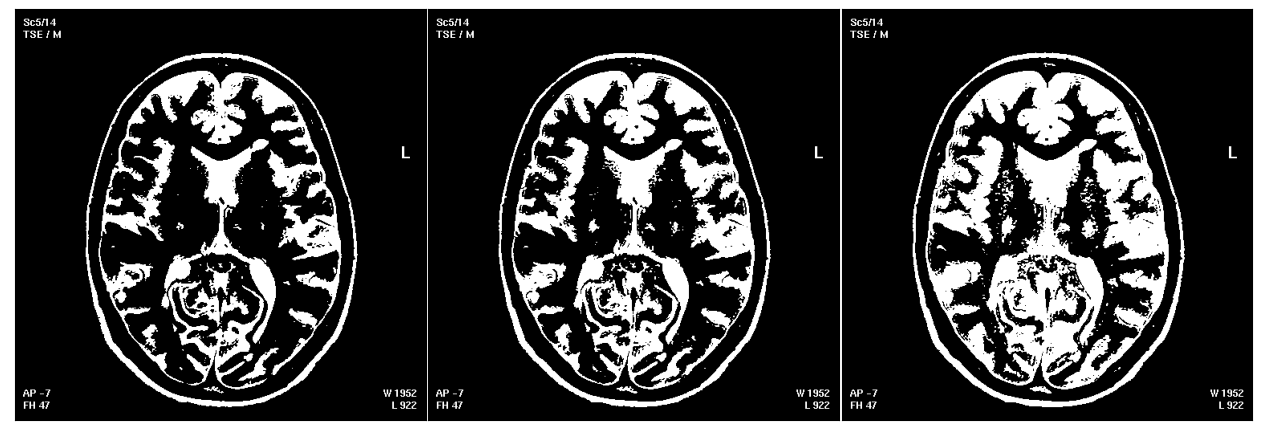

In [13]:
from scipy import stats as st

thresh, _ = otsu(denoised_equalized)
binarized = binarize(denoised_equalized, 100)


thresh_v = (
    round(np.mean(denoised_equalized[np.where(np.logical_and(denoised_equalized > 0, denoised_equalized < 255))])),
    round(np.median(denoised_equalized[np.where(np.logical_and(denoised_equalized > 0, denoised_equalized < 255))])),
)


binarized2 = binarize(denoised_equalized, thresh_v[0])
binarized3 = binarize(denoised_equalized, thresh_v[1])

imshow(binarized, binarized2, binarized3)

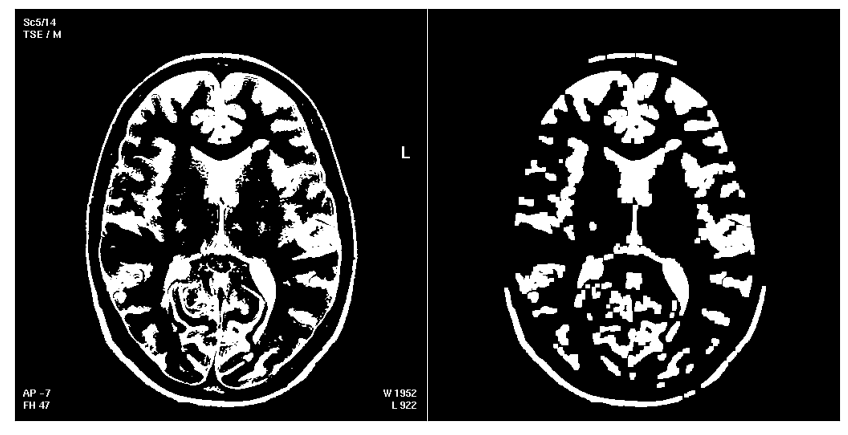

In [15]:
kernel = np.ones((5, 5), np.uint8)
opening = cv.morphologyEx(binarized2, cv.MORPH_OPEN, kernel, iterations=1)
imshow(binarized2, opening)

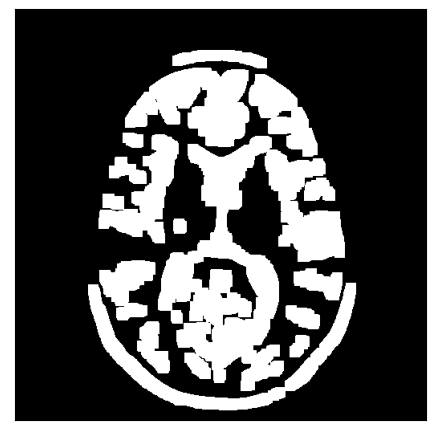

In [100]:
background = cv.dilate(opening, kernel, iterations=2)
imshow(background)

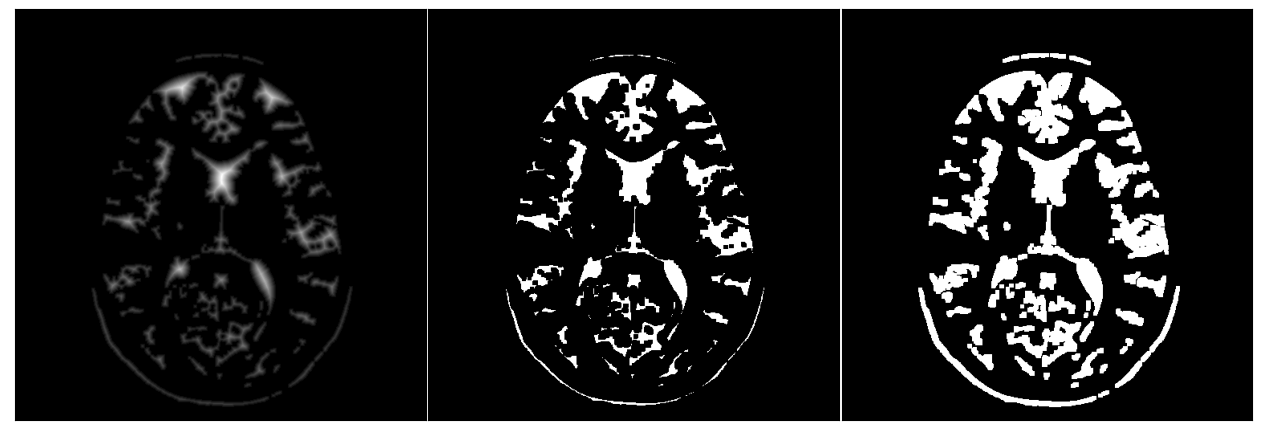

In [103]:
distance_transform = cv.distanceTransform(opening, cv.DIST_L2, maskSize=5)
_, foreground = cv.threshold(distance_transform, 0.0001 * distance_transform.max(), 255, 0)
foreground = np.uint8(foreground)
imshow(
    distance_transform,
    binarize(
        distance_transform,
        round(np.median(distance_transform[np.where(np.logical_and(distance_transform > distance_transform.mean(), distance_transform < distance_transform.max()))])),
    ),  # type: ignore
    foreground
)

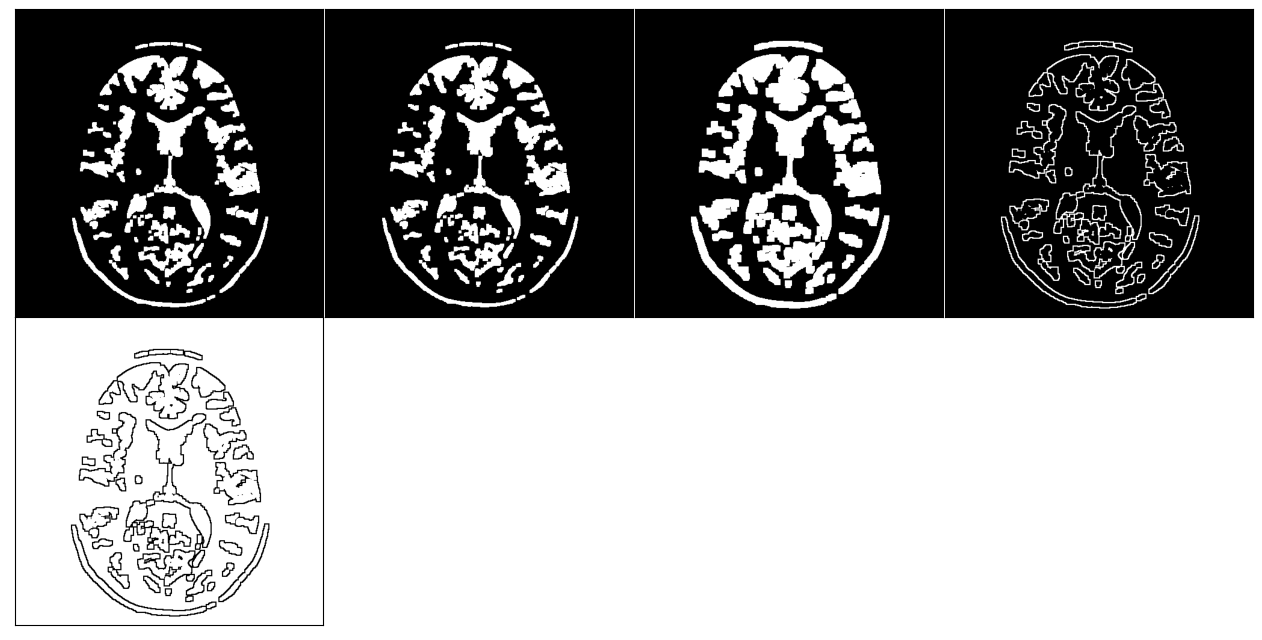

In [99]:
unknown = cv.subtract(background, foreground)
imshow(opening, foreground, background, unknown, 255 - unknown, cols=4)

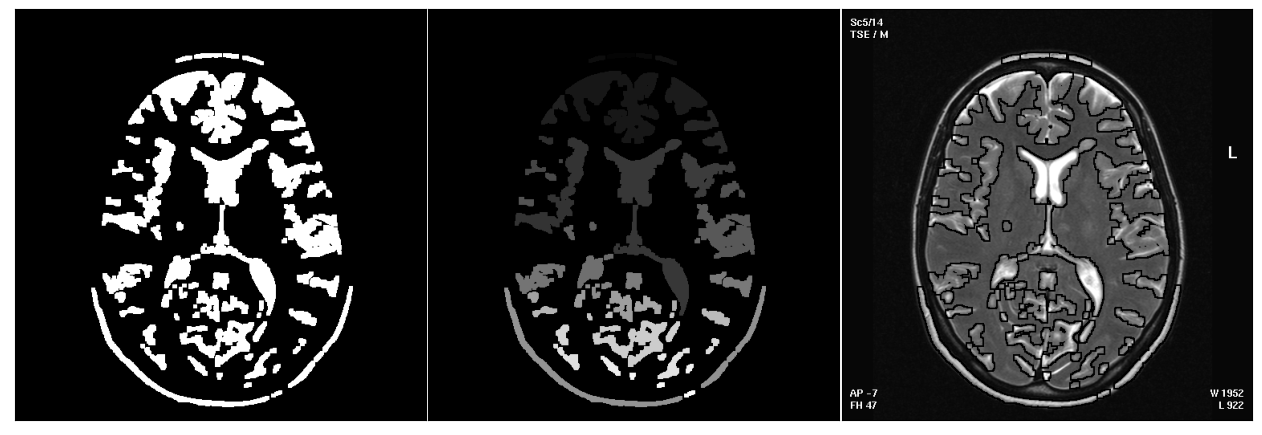

In [88]:
labels = image.copy()
_, markers = cv.connectedComponents(foreground)
# markers = markers + 1
labels[:,:,0][unknown == 1] = 0

imshow(foreground, markers, labels[:,:,0])

result = image.copy()

# markers = cv.watershed(result, markers)
# result[markers == -1] = [0, 0, 255]

# imshow(markers, result)

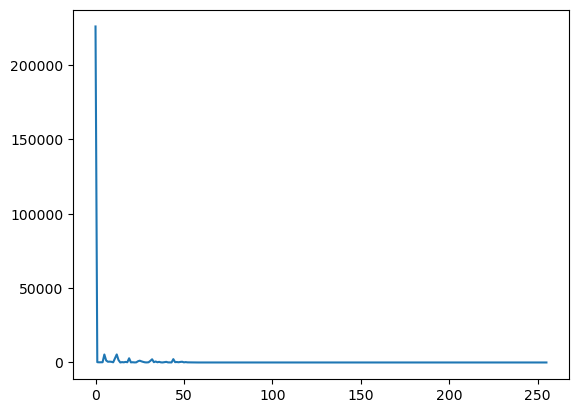

In [89]:
plt.plot(generate_histogram(markers))

In [58]:
# tmp_markers = markers.copy()
# tmp_markers[markers < 36] = 0 
# tmp_markers[markers > 40] = 0

# result = image.copy()
# result[:,:,0] = result[:,:,0] - tmp_markers
# result[:,:,1] = result[:,:,1] - tmp_markers
# result[:,:,2][tmp_markers != 0] = 255
# # result[tmp_markers != 0] = [0, 0, 200]

# imshow(
#     tmp_markers,
#     result[:,:,0],
#     result[:,:,1],
#     result[:,:,2],
#     # binarize(markers, 38),
#     # binarize(markers, 45),
#     result,
#     cols = 4
# )

(-1, 56, 3.7363853454589844, 1.0)

(1, 54, 19.820184652808493, 13.0)


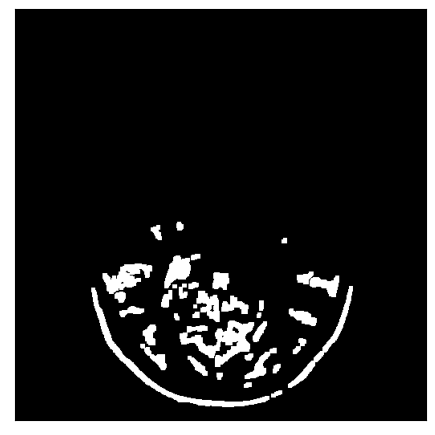

In [98]:
tmp_markers = markers.copy()
x = tmp_markers[np.where(np.logical_and(tmp_markers > tmp_markers.min(), tmp_markers < tmp_markers.max()))]
t = (x.min(), x.max(), x.mean(), np.median(x))

print(t)
# tmp_markers[markers < t[2]] = 0 
tmp_markers[markers <= t[2]] = 0
tmp_markers[markers > t[2]] = 255
# tmp_markers[markers >= t[1]] = 255
# # tmp_markers[markers > 40] = 0

# result = image.copy()
# result[:,:,0] = result[:,:,0] - tmp_markers
# result[:,:,1] = result[:,:,1] - tmp_markers
# result[:,:,2][tmp_markers != 0] = 255
# result[tmp_markers != 0] = [0, 0, 200]

imshow(
    tmp_markers,
#     result[:,:,0],
#     result[:,:,1],
#     result[:,:,2],
#     # binarize(markers, 38),
#     # binarize(markers, 45),
#     result,
#     cols = 4
)